In [1]:
import numpy as np
import pandas as pd
import random, tqdm
import matplotlib.pyplot as plt
import torch

**Image loading and resizing**

We have choosen 256x256

In [2]:
from src.create_numpies import create_np_images, create_np_masks

images = create_np_images("data/images", size = (256,256))
masks = create_np_masks("data/masks", size = (256,256))

# Shape corrections
masks = masks[:, :, :, 0].reshape(1000, 1, 256, 256)
masks = np.transpose(masks, (0, 2, 3, 1))

Generating masks numpy arrays: 100%|███████████████████████████████████████████████| 1000/1000 [00:05<00:00, 190.23it/s]


**Train-test splitting (60/40)**

In [3]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets
train_images, test_images, train_masks, test_masks = train_test_split(
    images, masks, test_size=0.4, random_state=42)

# Print the shapes of the train and test sets
print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Train masks shape:", train_masks.shape)
print("Test masks shape:", test_masks.shape)

Train images shape: (600, 256, 256, 3)
Test images shape: (400, 256, 256, 3)
Train masks shape: (600, 256, 256, 1)
Test masks shape: (400, 256, 256, 1)


**Data augmentation (on training set)**

In [6]:
import numpy as np
from tqdm import tqdm
import albumentations as A

# Define Albumentations transformations
transformations = A.Compose(
    [
        A.OneOrOther(
            A.Compose([
                A.RandomRotate90(),
                A.OneOf([
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)
                ], p=1)
            ]),
            A.Compose([
                A.Rotate(p=0.5),
                A.OneOf([
                    A.HueSaturationValue(p=0.5),
                    A.RGBShift(p=0.7)
                ], p=1)
            ])
        ),
        A.HorizontalFlip(p=1),
        A.RandomBrightnessContrast(p=0.5),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
        A.Blur(blur_limit=3, p=0.2),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.2),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.2)
    ]
)

# Create lists for storing the augmented images and masks
augmented_images = []
augmented_masks = []

# Number of times to apply augmentation for each image
num_augmentations = 4

# Apply transformations
for image, mask in tqdm(zip(train_images, train_masks), total=train_images.shape[0]):
    for _ in range(num_augmentations):
        # Apply Albumentations transformations
        augmented = transformations(image=image, mask=mask)
        augmented_images.append(augmented['image'])
        augmented_masks.append(augmented['mask'])

# Convert the lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Combine original and augmented images
combined_images = np.concatenate([train_images, augmented_images], axis=0)
combined_masks = np.concatenate([train_masks, augmented_masks], axis=0)

# Save them in the data folder
np.save("data/train_val_augmented/combined_images.npy", combined_images)
np.save("data/train_val_augmented/combined_masks.npy", combined_masks)

# Save test images in another folder
np.save("data/test/test_images.npy", test_images)
np.save("data/test/test_masks.npy", test_masks)

100%|█████████████████████████████████████████████████████████████████████████████████| 600/600 [01:51<00:00,  5.36it/s]


In [7]:
print("number of total images", len(combined_images))
print("number of total masks",len(combined_masks))

number of total images 3000
number of total masks 3000


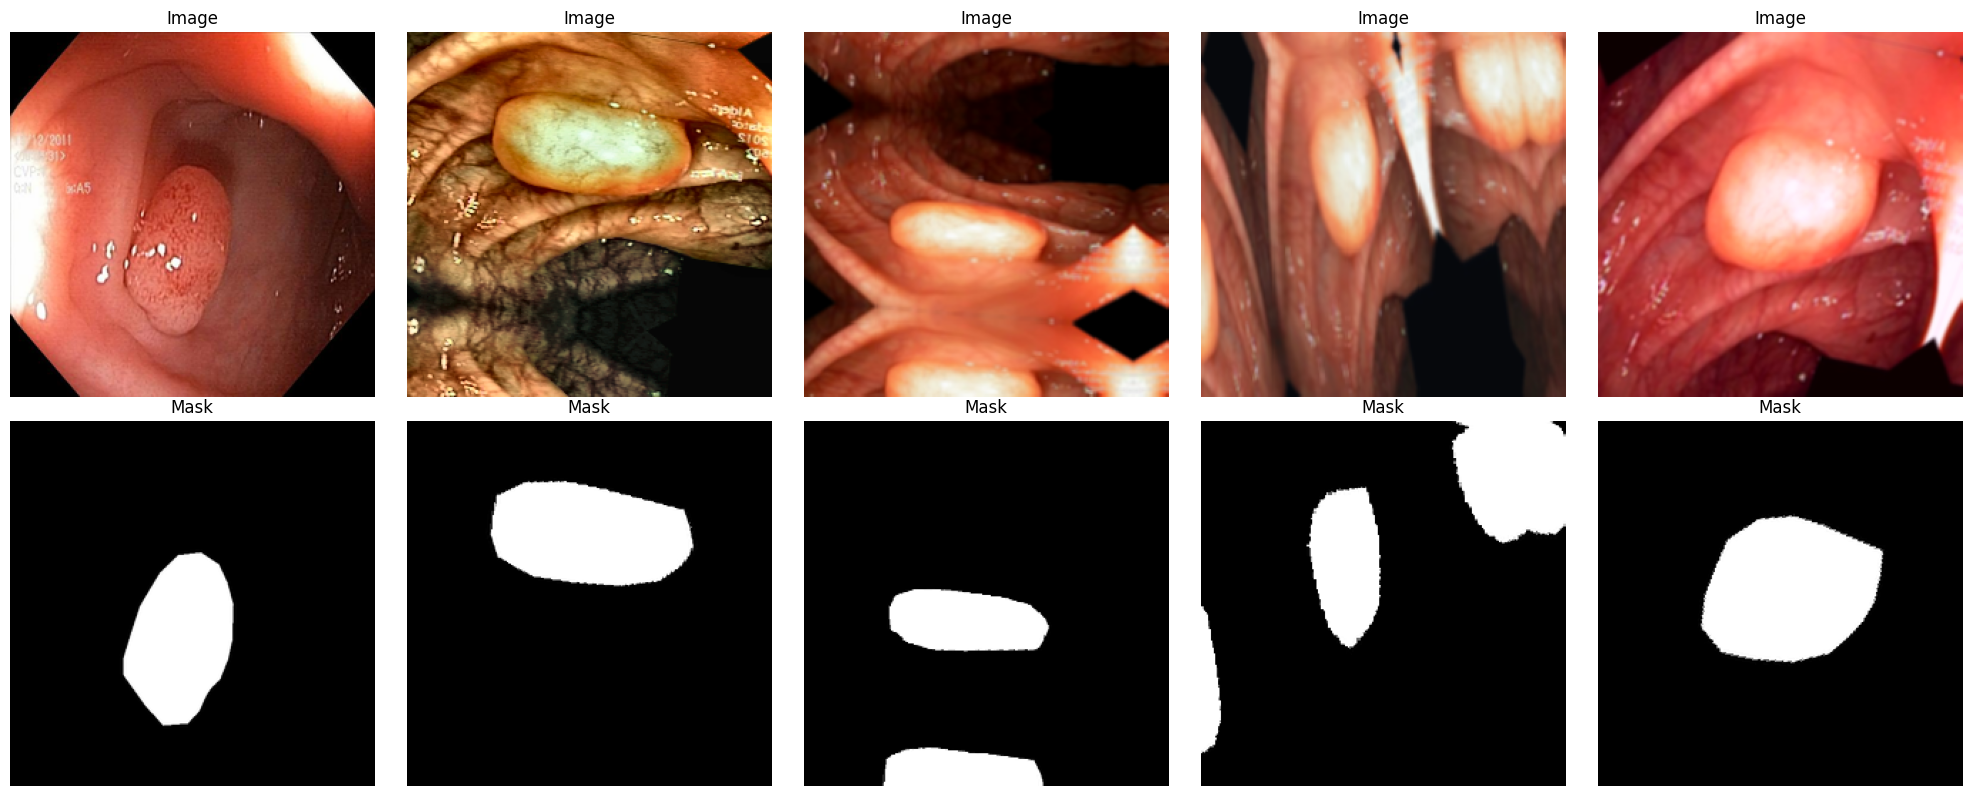

In [8]:
import matplotlib.pyplot as plt
import random

# Select 5 random indices
#random_indices = random.sample(range(len(combined_images)), 5)
random_indices = [0,1000,1001,1002, 1003]
# Create a subplot with a grid view to display images and masks
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Plot the 5 random images with their corresponding masks
for i, idx in enumerate(random_indices):
    # Plot the image
    axes[0, i].imshow(combined_images[idx])
    axes[0, i].set_title("Image")
    axes[0, i].axis('off')

    # Plot the mask
    axes[1, i].imshow(combined_masks[idx], cmap='gray')  # No need to specify cmap for grayscale masks
    axes[1, i].set_title("Mask")
    axes[1, i].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
